In [1]:
# %matplotlib notebook
from StatisticalArbitrage import StatisticalArbitrage as sta
from StatisticalArbitrageBacktest import StatisticalArbitrageBacktest as stab
from OrderStatus import OrderStatus
import matplotlib.pyplot as plt
import time, requests, json
from decouple import config
import pandas as pd
import numpy as np
import bitmex


## Variable ---

In [2]:
symbol1 = 'BTCUSDT'
symbol2 = 'BCHUSDT'

tick_interval = '1m'
tick_interval_small = '5m'

### CSV Paths for Data
symbol1Path = './data/'+symbol1+'_'+tick_interval+'.csv'
symbol2Path = './data/'+symbol2+'_'+tick_interval+'.csv'

symbol1Path_small = './data/'+symbol1+'_'+tick_interval_small+'.csv'
symbol2Path_small = './data/'+symbol2+'_'+tick_interval_small+'.csv'

symbolcomposite = '.BBCHXBT'

data_count = 20000
bitmex_max_count = 1000

current_balance = starting_capital = 10000
algo_stop_balance = 0.1 * starting_capital

rolling_window = 75
sell_periods = 1

z_score_buy_threshold = -3
z_score_short_threshold = 3

transaction_fee = 0.05/100

leverage = 20

In [3]:
# sta.saveSymbolsToCSV(symbol1,symbol2,tick_interval)
# sta.saveSymbolsToCSV(symbol1,symbol2,tick_interval_small)

past_dataframe_symbol1,past_dataframe_symbol2 = sta.loadSymbolsFromCSV(symbol1Path,symbol2Path)
ticker_main_df = sta.getMainDataFrame(symbol1,symbol2,past_dataframe_symbol1,past_dataframe_symbol2)

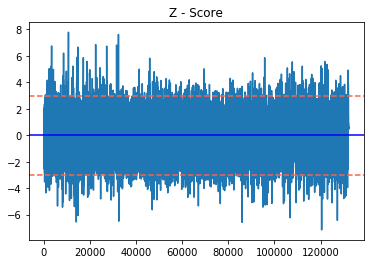

In [4]:
ticker_main_df = sta.zScoreDF(ticker_main_df,rolling_window,symbol1,symbol2)
sta.plotZScore(ticker_main_df,z_score_buy_threshold,z_score_short_threshold)

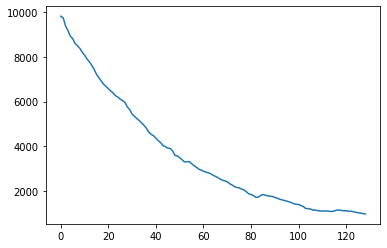

In [5]:

 back = stab(starting_capital,
                        algo_stop_balance,
                        sell_periods,
                        leverage,
                        transaction_fee,
                        z_score_buy_threshold,
                        z_score_short_threshold,
                        symbol1,symbol2,ticker_main_df)      
current_balance,balance_list,order_details = back.runBacktest()
cap_returns = round((current_balance -starting_capital) *100/current_balance)

fig = plt.figure()
plt.plot(balance_list)
plt.show()

In [6]:
print(cap_returns)

-912


In [7]:
order_details

,count,order_type,balance_prior,balance_post,total_pnl,total_returns,order_id_price_symbol1,price_symbol1,balance_alloc_symbol,quantity_symbol1,...,pnl_symbol1,returns_symbol1,order_id_price_symbol2,price_symbol2,balance_alloc_symbol2,quantity_symbol2,squareOff_price_symbol2,squareOff_bal_symbol2,pnl_symbol2,returns_symbol2
0,1,OrderStatus.LONG,10000,9810.422943,-189.577057,0,0,10500.00,100000.000000,0,...,-20.611143,0,0,217.24,100000.000000,0,217.39,0,-168.965914,0
0,2,OrderStatus.LONG,9810.42,9737.395025,-73.027919,0,0,10492.25,98104.229433,0,...,-83.431816,0,0,217.12,98104.229433,0,216.88,0,10.403897,0
0,3,OrderStatus.LONG,9737.4,9379.526031,-357.868994,0,0,10483.05,97373.950246,0,...,-126.061695,0,0,216.89,97373.950246,0,217.19,0,-231.807299,0
0,4,OrderStatus.LONG,9379.53,9170.674309,-208.851722,0,0,10470.29,93795.260307,0,...,-84.841510,0,0,217.12,93795.260307,0,217.19,0,-124.010212,0
0,5,OrderStatus.LONG,9170.67,8918.293118,-252.381190,0,0,10538.81,91706.743086,0,...,-106.318478,0,0,219.09,91706.743086,0,219.22,0,-146.062713,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,125,OrderStatus.SHORT,1087.63,1067.729296,-19.897645,0,0,10923.51,10876.269411,0,...,-13.671999,0,0,233.75,10876.269411,0,233.85,0,-6.225646,0
0,126,OrderStatus.SHORT,1067.73,1041.145856,-26.583439,0,0,10925.57,10677.292957,0,...,-5.879113,0,0,234.15,10677.292957,0,233.93,0,-20.704327,0
0,127,OrderStatus.SHORT,1041.15,1023.729810,-17.416046,0,0,10938.15,10411.458564,0,...,-2.547185,0,0,233.46,10411.458564,0,233.36,0,-14.868861,0
0,128,OrderStatus.SHORT,1023.73,1004.816178,-18.913633,0,0,10915.03,10237.298102,0,...,-11.736981,0,0,234.02,10237.298102,0,234.09,0,-7.176651,0


In [8]:
order_details.to_csv('./data/OrderDetails.csv',index=False)